# Multiple Output Models using the Keras Functional API

## Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import utils

## Load Dataset

In [ ]:
URI = './winequality-white.csv'
white_df = pd.read_csv(URI, sep=";")
white_df.insert(white_df.shape[1], "is_red", np.zeros(white_df.shape[0], dtype=np.int64))
white_df = white_df.drop_duplicates(keep='first')

### Pre-process the red wine dataset

In [ ]:
URI = './winequality-red.csv'
red_df = pd.read_csv(URI, sep=";")
red_df.insert(red_df.shape[1], "is_red", np.ones(red_df.shape[0], dtype=np.int64))
red_df = red_df.drop_duplicates(keep='first')

### Concatenate the datasets

In [ ]:
df = pd.concat([red_df, white_df], ignore_index=True)

In [ ]:
df = df.iloc[np.random.permutation(len(df))]

This will chart the quality of the wines.

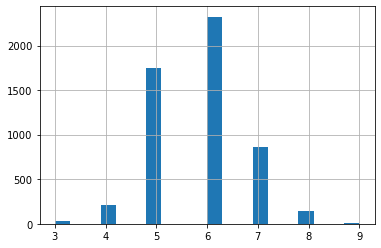

In [ ]:
df['quality'].hist(bins=20);

### Imbalanced data

In [ ]:
df = df[df['quality'] < 8]
df = df[df['quality'] > 4]
df = df.reset_index(drop=True)

##### plot ew range of data and quality

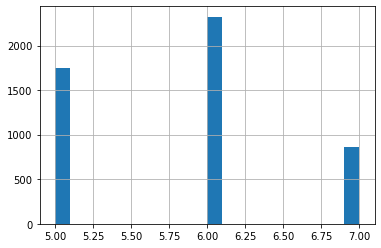

In [ ]:
df['quality'].hist(bins=20);

### Train Test Split

In [ ]:
train, test = train_test_split(df, test_size=.2, random_state = 1)                               
train, val = train_test_split(train, test_size=.2, random_state = 1)

In [ ]:
utils.test_data_sizes(train.size, test.size, val.size)



 All public tests passed


##### pop the labels 'is_red' and 'quality' from the data, these will be used as the labels

In [ ]:
train_stats = train.describe()
train_stats.pop('is_red')
train_stats.pop('quality')
train_stats = train_stats.transpose()

In [ ]:
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3155.0,7.228479,1.327402,4.20000,6.4000,7.00000,7.7000,15.90000
volatile acidity,3155.0,0.337800,0.162583,0.08000,0.2300,0.29000,0.4000,1.33000
citric acid,3155.0,0.319848,0.147868,0.00000,0.2500,0.31000,0.4000,1.66000
residual sugar,3155.0,5.181474,4.594497,0.70000,1.8000,2.80000,7.7000,65.80000
chlorides,3155.0,0.056688,0.035016,0.01200,0.0380,0.04700,0.0660,0.61100
free sulfur dioxide,3155.0,30.611886,17.399840,1.00000,17.0000,29.00000,42.0000,131.00000
total sulfur dioxide,3155.0,114.858954,56.744014,6.00000,76.0000,117.00000,155.0000,344.00000
density,3155.0,0.994614,0.003010,0.98711,0.9923,0.99479,0.9968,1.03898
pH,3155.0,3.221772,0.157175,2.74000,3.1200,3.21000,3.3200,4.01000
sulphates,3155.0,0.534846,0.145432,0.22000,0.4400,0.51000,0.6000,1.95000


### Get the labels

In [ ]:
def format_output(data):
    is_red = data.pop('is_red')
    is_red = np.array(is_red)
    quality = data.pop('quality')
    quality = np.array(quality)
    return (quality, is_red)

In [ ]:
train_Y = format_output(train)
val_Y = format_output(val)
test_Y = format_output(test)

In [ ]:
utils.test_format_output(df, train_Y, val_Y, test_Y)

 All public tests passed


In [ ]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
225,6.9,0.25,0.40,1.3,0.038,22.0,101.0,0.99010,3.03,0.39,11.4
3557,6.1,0.27,0.33,2.2,0.021,26.0,117.0,0.98860,3.12,0.30,12.5
3825,6.7,0.18,0.25,14.3,0.048,79.0,149.0,0.99750,3.12,0.37,9.7
1740,6.2,0.36,0.14,8.9,0.036,38.0,155.0,0.99622,3.27,0.50,9.4
1221,5.8,0.20,0.24,1.4,0.033,65.0,169.0,0.99043,3.59,0.56,12.3


### Normalize the data

In [ ]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [ ]:
norm_train_X = norm(train)
norm_val_X = norm(val)
norm_test_X = norm(test)

In [ ]:
utils.test_norm(norm_train_X, norm_val_X, norm_test_X, train, val, test)


 All public tests passed


## Define the Model

In [ ]:
def base_model(inputs):
    x = tf.keras.layers.Dense(units=128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(units=128, activation='relu')(x)
    return x

# Define output layers of the model

In [ ]:
def final_model(inputs):
    x = base_model(inputs)
    wine_quality = Dense(units='1', name='wine_quality')(x)
    wine_type = Dense(units='1', activation='sigmoid', name='wine_type')(x)
    model = Model(inputs=inputs, outputs=(wine_quality, wine_type))
    return model

## Compiling the Model

In [ ]:
inputs = tf.keras.layers.Input(shape=(11,))
rms = tf.keras.optimizers.RMSprop(lr=0.0001)
model = final_model(inputs)
model.compile(optimizer=rms, 
              loss={'wine_type': 'binary_crossentropy', 'wine_quality': 'mean_squared_error'},
              metrics={'wine_type': 'accuracy', 'wine_quality': tf.keras.metrics.RootMeanSquaredError(name='root_mean_squared_error', dtype=None)})


## Training the Model

In [ ]:
history = model.fit(x=norm_train_X, y=train_Y, epochs = 40, validation_data=(norm_val_X, val_Y))

Train on 3155 samples, validate on 789 samples
Epoch 1/40
3155/3155 [==============================] - 1s 431us/sample - loss: 25.3837 - wine_quality_loss: 24.6677 - wine_type_loss: 0.6870 - wine_quality_root_mean_squared_error: 4.9696 - wine_type_accuracy: 0.6330 - val_loss: 17.2472 - val_wine_quality_loss: 16.6095 - val_wine_type_loss: 0.6688 - val_wine_quality_root_mean_squared_error: 4.0716 - val_wine_type_accuracy: 0.6844
Epoch 2/40
3155/3155 [==============================] - 0s 119us/sample - loss: 10.8447 - wine_quality_loss: 10.1785 - wine_type_loss: 0.6408 - wine_quality_root_mean_squared_error: 3.1943 - wine_type_accuracy: 0.7119 - val_loss: 5.8713 - val_wine_quality_loss: 5.2908 - val_wine_type_loss: 0.5937 - val_wine_quality_root_mean_squared_error: 2.2972 - val_wine_type_accuracy: 0.7668
Epoch 3/40
3155/3155 [==============================] - 0s 123us/sample - loss: 3.8389 - wine_quality_loss: 3.3046 - wine_type_loss: 0.5241 - wine_quality_root_mean_squared_error: 1.8205 

In [ ]:
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_accuracy = model.evaluate(x=norm_val_X, y=val_Y)
print()
print(f'loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_type_accuracy: {wine_type_accuracy}')

789/789 [==============================] - 0s 23us/sample - loss: 0.3841 - wine_quality_loss: 0.3510 - wine_type_loss: 0.0338 - wine_quality_root_mean_squared_error: 0.5917 - wine_type_accuracy: 0.9962

loss: 0.38413156925952024
wine_quality_loss: 0.35096943378448486
wine_type_loss: 0.0337824709713459
wine_quality_rmse: 0.5917472839355469
wine_type_accuracy: 0.9961977005004883


## Analyze the Model Performance

In [ ]:
predictions = model.predict(norm_test_X)
quality_pred = predictions[0]
type_pred = predictions[1]

### Plot Utilities

In [ ]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

In [ ]:
def plot_diff(y_true, y_pred, title = '' ):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100, 100], [-100, 100])
    return plt

### Plots for Metrics

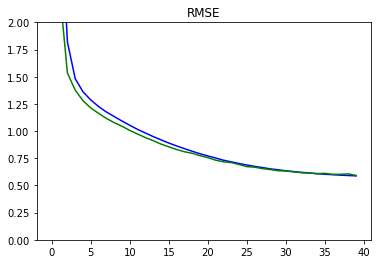

In [ ]:
plot_metrics('wine_quality_root_mean_squared_error', 'RMSE', ylim=2)

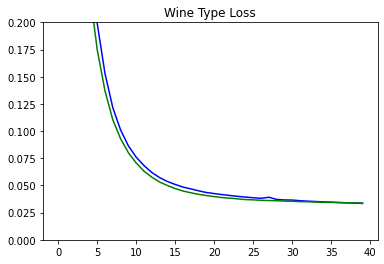

In [ ]:
plot_metrics('wine_type_loss', 'Wine Type Loss', ylim=0.2)

### Plots for Confusion Matrix

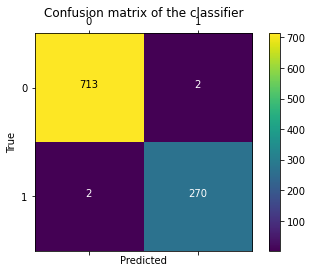

In [ ]:
plot_confusion_matrix(test_Y[1], np.round(type_pred), title='Wine Type', labels = [0, 1])

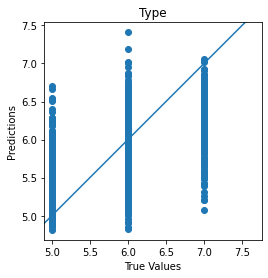

In [ ]:
scatter_plot = plot_diff(test_Y[0], quality_pred, title='Type')